In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Chest X-Ray Deep Learning Transfer Learning with Three Popular CNN Models

## Objective
This notebook aims to try three popular CNN models for image classification. DenseNet-169, Resnet-152V2, and MobileNetV2 are all pre-trained models that have been show to produce great results in classification. By using transfer learning and taking these models pre-trained layers, we can see how the base models perform on X-ray classification for pneumonia, without any new layers for training and without hyperparameter optimization. This will serve as a baseline for selecting a model for further optimization through adding Dense layers and hyperparameter optimization later. But first, it is important to do a quick analysis to choose a model to start with. For a quick glance and the results from this notebook, read the below summary.


## Summary of Results for the Three Baseline Models

**DenseNet-169** performed the **best** both on the training/testing data but also on the validation data. During training, the **validation loss reached 0.53**. For the holdout validation data, it had **100% accuracy**. This was a small validation dataset of only 16 images, so it would be good to find a dataset with more images for validation.

**Resnet-152V2** performed the **worst** on the training/testing data. During training, the **validation loss reached only 0.75**. For the holdout validation data, it had **94% accuracy**. Once again, this is a small validation dataset, and this needs to be further analyzed on a larger validation dataset.

**MobileNetV2** performed in the **middle** on the training/testing data. During training, the **validation loss reached 0.67**. For the holdout validation data, it had **94% accuracy**. This is too small of a validation dataset to make any major conclusions.

## Next Steps

- Find a larger x-ray image dataset that can include a larger holdout validation set
- Perform baseline models on the larger dataset
- Create augmented x-ray images for training and testing (no augmentation for holdout validation)
- Add trainable layers onto the base model and perform hyperparameter optimization

## Import Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout, Flatten
from tensorflow.keras.applications.densenet import DenseNet169
%matplotlib inline



In [4]:


# create directory variables for easy access to data
main_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_data_dir = main_dir + 'train/'
validation_data_dir = main_dir + 'val/'
test_data_dir = main_dir + 'test/'
train_n = train_data_dir + 'NORMAL/'
train_p = train_data_dir + 'PNEUMONIA/'
valid_n = validation_data_dir + 'NORMAL/'
valid_p = validation_data_dir + 'PNEUMONIA/'



In [5]:
# Split the images into normal and pneumonia
normal_images = [fn for fn in os.listdir(train_n) if fn.endswith('.jpeg')]
pneumonia_images = [fn for fn in os.listdir(train_p) if fn.endswith('.jpeg')]



## Create a Data Generator

In [6]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)
val_datagen = ImageDataGenerator(rescale= 1./255)

### Load the Data into the Data Generator

In [7]:
img_width, img_height = [224, 224]
batch_size = 16

In [8]:
# load the training data generator
train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

Found 5216 images belonging to 2 classes.


In [9]:
# load the validation data generator
validation_generator = val_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=False)

Found 16 images belonging to 2 classes.


In [10]:
# load the testing data generator
test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

Found 624 images belonging to 2 classes.


## Plot Images from the Data Generator

In [11]:
# iterate through the generator of training images
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    # iterate through 10 images
    for n in range(10):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

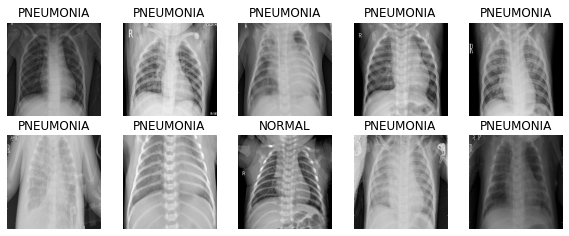

In [12]:
# display 10 images of training batch
show_batch(image_batch, label_batch)

## Build DenseNet169 Model for Baseline Performance

In [13]:
input_shape = (224, 224, 3)
input_layer = Input(shape = (224, 224, 3))

In [14]:
# baseline densenet model
densenet_base = DenseNet169(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )


2022-05-23 19:06:32.433755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 19:06:32.550050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 19:06:32.550950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 19:06:32.552131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step


In [15]:
# freeze the layers of the base model
for layer in densenet_base.layers:
    layer.trainable = False

In [16]:
# view the model architecture
densenet_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

#### This is a large model with a lot of layers. All the layers are frozen and won't be trained for this baseline.

#### An Output Layer with a sigmoid activation needs to added to the model

In [17]:
# create the output layer with one node and use sigmoid activation
densenet_model = Sequential()
densenet_model.add(densenet_base)
densenet_model.add(Flatten())
densenet_model.add(Dense(activation='sigmoid', units = 1))

## Run the Model

Use Adam optimizer and learning rate of 0.0001

In [18]:
optm = Adam(learning_rate=0.0001)
densenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['accuracy'])

In [19]:
# create call backs for early stopping
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=.01,
                            patience=6,
                            verbose=1,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True)

In [20]:
from keras.callbacks import ModelCheckpoint

model_save = ModelCheckpoint('./densenet169_baseline.h5',
                            save_best_only = True,
                            save_weights_only = False,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)

## Training the Model

In [21]:
nb_train_samples = 5216
nb_validation_samples = 16
nb_test_samples = 624
epochs = 20
batch_size = 16

In [22]:
densenet_history = densenet_model.fit(train_generator,
                                    steps_per_epoch = nb_train_samples//batch_size,
                                    epochs = epochs,
                                    validation_data = test_generator,
                                    callbacks = [EarlyStopping, model_save])
                        

2022-05-23 19:06:40.936507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-23 19:06:50.008244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


326/326 [==============================] - 115s 309ms/step - loss: 0.1038 - accuracy: 0.9615 - val_loss: 0.5268 - val_accuracy: 0.8285

Epoch 00001: val_loss improved from inf to 0.52684, saving model to ./densenet169_baseline.h5
Epoch 2/20
326/326 [==============================] - 71s 217ms/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.6200 - val_accuracy: 0.8141

Epoch 00002: val_loss did not improve from 0.52684
Epoch 3/20
326/326 [==============================] - 72s 220ms/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.7583 - val_accuracy: 0.7933

Epoch 00003: val_loss did not improve from 0.52684
Epoch 4/20
326/326 [==============================] - 71s 218ms/step - loss: 0.0127 - accuracy: 0.9977 - val_loss: 1.4645 - val_accuracy: 0.7019

Epoch 00004: val_loss did not improve from 0.52684
Epoch 5/20
326/326 [==============================] - 70s 214ms/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 0.8360 - val_accuracy: 0.8029

Epoch 00005: val_loss did not imp

## Validate the DenseNet-169 Model

Use the validation data to make predictions and compare the predictions with the actual classification. Since it is important to understand what the true classification is of the x-ray, it will be easier to understand which images are being predicted by using a dataframe for the data generator.

In [23]:
# create a dictionary for storing path and class for the validation set
path_list = []
class_list = []
for dirname, _, filenames in os.walk(validation_data_dir):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        
        path_list.append(path)
        # assign the classification to the path
        if "NORMAL" in dirname:
            class_list.append('NORMAL')
        else:
            class_list.append('PNEUMONIA')
        
valid_dict = {'path':path_list, 'class':class_list}

In [24]:
valid_df = pd.DataFrame(valid_dict)
valid_df

,path,class
0,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
5,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
6,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
7,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
8,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL
9,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL


In [25]:
validation_generator = val_datagen.flow_from_dataframe(
                    dataframe = valid_df,
                    x_col = 'path',
                    y_col = 'class',
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=False)

Found 16 validated image filenames belonging to 2 classes.


In [26]:
valX, valY = validation_generator.next()

In [27]:
from tensorflow.keras.models import load_model

saved_model = load_model('./densenet169_baseline.h5')

pred_Y = saved_model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 2s 2s/step


In [28]:
preds_Y = np.where(pred_Y > 0.5, 1, 0)
preds_Y

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [29]:
from sklearn.metrics import classification_report

print(classification_report(valY, preds_Y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



## Load the ResNet-152V2 Model

In [30]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

# instantiate the base resnet model
resnet_base = ResNet152V2(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )

#freeze the layers of the base model
for layer in resnet_base.layers:
    layer.trainable = False
    
    
# create the output layer with one node and use sigmoid activation
resnet_model = Sequential()
resnet_model.add(resnet_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(activation='sigmoid', units = 1))

234561536/234545216 [==============================] - 1s 0us/step


## Train the ResNet-152V2 Model

In [31]:
# compile the metrics for training the model
optm = Adam(learning_rate=0.0001)
resnet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['accuracy']
                    )

In [32]:
# create a new model saving checkpoint path
model_save = ModelCheckpoint('./resnet_baseline.h5',
                            save_best_only = True,
                            save_weights_only = False,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)

In [33]:
resnet_history = resnet_model.fit(train_generator,
                                    steps_per_epoch = nb_train_samples//batch_size,
                                    epochs = epochs,
                                    validation_data = test_generator,
                                    callbacks = [EarlyStopping, model_save])

Epoch 1/20
326/326 [==============================] - 83s 231ms/step - loss: 0.1324 - accuracy: 0.9534 - val_loss: 0.9340 - val_accuracy: 0.7788

Epoch 00001: val_loss improved from inf to 0.93396, saving model to ./resnet_baseline.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
326/326 [==============================] - 73s 223ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.7516 - val_accuracy: 0.8093

Epoch 00002: val_loss improved from 0.93396 to 0.75158, saving model to ./resnet_baseline.h5
Epoch 3/20
326/326 [==============================] - 74s 227ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 1.1016 - val_accuracy: 0.7772

Epoch 00003: val_loss did not improve from 0.75158
Epoch 4/20
326/326 [==============================] - 73s 222ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.8482 - val_accuracy: 0.8141

Epoch 00004: val_loss did not improve from 0.75158
Epoch 5/20
326/326 [==============================] - 74s 226ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0174 - val_accuracy: 0.7981

Epoch 00005: val_loss did not improve from 0.75158
Epoch 6/20
326/326 [==============================] - 73s 223ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0763 - val_accuracy: 0.7981

Epoch 00006: val_loss di

## Validate the ResNet-152V2 Model

In [34]:
validation_generator = val_datagen.flow_from_dataframe(
                    dataframe = valid_df,
                    x_col = 'path',
                    y_col = 'class',
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=False)

Found 16 validated image filenames belonging to 2 classes.


In [35]:
valX, valY = validation_generator.next()

In [37]:
# load the best model saved from training
saved_model = load_model('./resnet_baseline.h5')

pred_Y = saved_model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 3s 3s/step


In [38]:
# set the threshold for 0.5 for classification
y_preds = np.where(pred_Y > 0.5, 1, 0)

y_preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [39]:
print(classification_report(valY, y_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



## Load the MobileNetV2

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# instantiate the base mobilenet model
mobilenet_base = MobileNetV2(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )

#freeze the layers of the base model
for layer in mobilenet_base.layers:
    layer.trainable = False
    
    
# create the output layer with one node and use sigmoid activation
mobilenet_model = Sequential()
mobilenet_model.add(mobilenet_base)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(activation='sigmoid', units = 1))

9420800/9406464 [==============================] - 0s 0us/step


## Train the MobileNetV2 Model

In [41]:
# compile the metrics for training the model
optm = Adam(learning_rate=0.0001)
mobilenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['accuracy']
                    )

In [42]:
# create a new model saving checkpoint path
model_save = ModelCheckpoint('./mobilenet_baseline.h5',
                            save_best_only = True,
                            save_weights_only = False,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)

In [44]:
mobilenet_history = mobilenet_model.fit(train_generator,
                                    steps_per_epoch = nb_train_samples//batch_size,
                                    epochs = epochs,
                                    validation_data = test_generator,
                                    callbacks = [EarlyStopping, model_save])

Epoch 1/20
326/326 [==============================] - 69s 205ms/step - loss: 0.1112 - accuracy: 0.9572 - val_loss: 0.6759 - val_accuracy: 0.8077

Epoch 00001: val_loss improved from inf to 0.67590, saving model to ./mobilenet_baseline.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
326/326 [==============================] - 66s 201ms/step - loss: 0.0332 - accuracy: 0.9881 - val_loss: 0.6719 - val_accuracy: 0.8157

Epoch 00002: val_loss improved from 0.67590 to 0.67194, saving model to ./mobilenet_baseline.h5
Epoch 3/20
326/326 [==============================] - 67s 206ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.7426 - val_accuracy: 0.8109

Epoch 00003: val_loss did not improve from 0.67194
Epoch 4/20
326/326 [==============================] - 65s 201ms/step - loss: 0.0078 - accuracy: 0.9994 - val_loss: 0.9759 - val_accuracy: 0.7837

Epoch 00004: val_loss did not improve from 0.67194
Epoch 5/20
326/326 [==============================] - 66s 204ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 1.2226 - val_accuracy: 0.7644

Epoch 00005: val_loss did not improve from 0.67194
Epoch 6/20
326/326 [==============================] - 66s 202ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.9935 - val_accuracy: 0.7869

Epoch 00006: val_loss

## Validate the MobileNetV2

In [45]:
# load the best model saved from training
saved_model = load_model('./mobilenet_baseline.h5')

pred_Y = saved_model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 1s 599ms/step


In [46]:
# set the threshold for 0.5 for classification
y_preds = np.where(pred_Y > 0.5, 1, 0)

y_preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [47]:
print(classification_report(valY, y_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93         8
         1.0       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



## Analysis of the Three Baseline Models

**DenseNet-169** performed the **best** both on the training/testing data but also on the validation data. During training, the **validation loss reached 0.53**. For the holdout validation data, it had **100% accuracy**. This was a small validation dataset of only 16 images, so it would be good to find a dataset with more images for validation.

**Resnet-152V2** performed the **worst** on the training/testing data. During training, the **validation loss reached only 0.75**. For the holdout validation data, it had **94% accuracy**. Once again, this is a small validation dataset, and this needs to be further analyzed on a larger validation dataset.

**MobileNetV2** performed in the **middle** on the training/testing data. During training, the **validation loss reached 0.67**. For the holdout validation data, it had **94% accuracy**. This is too small of a validation dataset to make any major conclusions.

## Next Steps

- Find a larger x-ray image dataset that can include a larger holdout validation set
- Perform baseline models on the larger dataset
- Create augmented x-ray images for training and testing (no augmentation for holdout validation)
- Add trainable layers onto the base model and perform hyperparameter optimization